# Import all kind of stuff

In [1]:
import numpy as np

from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D

import superconductivity.api as sc

from superconductivity.api import G_0_muS
from superconductivity.api import NDArray64

from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("reload_ext", "autoreload")
    _ip.run_line_magic("autoreload", "2")

    _ip.run_line_magic(
        "config",
        "InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}",
    )
    _ip.run_line_magic("config", 'InlineBackend.figure_format = "retina"')  # or "png"
    _ip.run_line_magic(
        "config", "InlineBackend.rc = {'figure.dpi': 300}"
    )  # choose a value you like

In [2]:
tau = np.array([0.8, 0.1, 0.1])
G_N = np.sum(tau)

sc.get_Ic_abs(Delta_meV=0.18, tau=1, T_K=0.1), sc.get_Ic_ab(
    Delta_meV=0.18, G_N=1, T_K=0.1
)

(np.float64(3.009503089794344), np.float64(1.5707631452657465))

# PAMAR I--V

In [3]:
V_bias = np.linspace(-3, 3, 2001)
zero_mask = V_bias >= 0

tau = np.array([0.8, 0.1, 0.1])
# tau = np.array([0.66])
G_N = np.sum(tau)

Delta_meV = 0.180
T_K = 0.1
gamma_meV = 0.0

V_bias_mV = V_bias * Delta_meV

I_fcs_nA = np.zeros((tau.shape[0], V_bias.shape[0], 10))
I_ha_nA = np.zeros((tau.shape[0], V_bias.shape[0]))
for i_tau, tau_i in enumerate(tau):
    i_fcs_nA = sc.get_I_fcs_nA(
        V_mV=V_bias_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
    )
    i_ha_nA = sc.get_I_ha_nA(
        V_mV=V_bias_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
    )
    I_fcs_nA[i_tau, :, :] = i_fcs_nA[:, 1:]
    I_ha_nA[i_tau, :] = i_ha_nA

I_bcs_nA = sc.get_I_bcs_nA(
    V_mV=V_bias_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_fcs_nA = np.sum(I_fcs_nA, axis=0)
I_ha_nA = np.sum(I_ha_nA, axis=0)

I_bcs = I_bcs_nA / (G_0_muS * Delta_meV)
I_fcs = I_fcs_nA / (G_0_muS * Delta_meV)
I_ha = I_ha_nA / (G_0_muS * Delta_meV)

dIdV_fcs = np.gradient(I_fcs, V_bias, axis=0)
dIdV_ha = np.gradient(I_ha, V_bias)
dIdV_bcs = np.gradient(I_bcs, V_bias)

cached values: 1001/1001
cached values: 1001/1001
cached values: 1001/1001


In [4]:
A_bias = np.linspace(0, 3, 1001)
m = np.arange(1, 11, 1)
nu_GHz = 10.0

A_bias_interest = [0, 0.3, 0.6]
idx = np.searchsorted(A_bias, A_bias_interest)

A_bias_mV = A_bias * Delta_meV
I_pat_m_nA = np.zeros((m.shape[0], A_bias.shape[0], V_bias.shape[0]))

for i_m, m_i in enumerate(m):
    I_fcs_m_nA = I_fcs_nA[:, i_m]
    I_pat_m_nA[i_m, :, :] = sc.get_I_pat_nA(
        V_mV=V_bias_mV,
        I_nA=I_fcs_m_nA,
        A_mV=A_bias_mV,
        nu_GHz=nu_GHz,
        m=m_i,
    )

I_pat_m = I_pat_m_nA / (G_0_muS * Delta_meV)
I_pamar = np.sum(I_pat_m, axis=0)

dIdV_pat_m = np.gradient(I_pat_m, V_bias, axis=2)
# dIdV_pat_m = np.where(dIdV_pat_m >= 0, dIdV_pat_m, 0.0)

dIdV_pamar = np.sum(dIdV_pat_m, axis=0)

I_pat_nA = sc.get_I_pat_nA(
    V_mV=V_bias_mV,
    I_nA=I_bcs_nA,
    A_mV=A_bias_mV,
    nu_GHz=nu_GHz,
    m=1,
)
I_pat = I_pat_nA / (G_0_muS * Delta_meV)
dIdV_pat = np.gradient(I_pat, V_bias, axis=1)

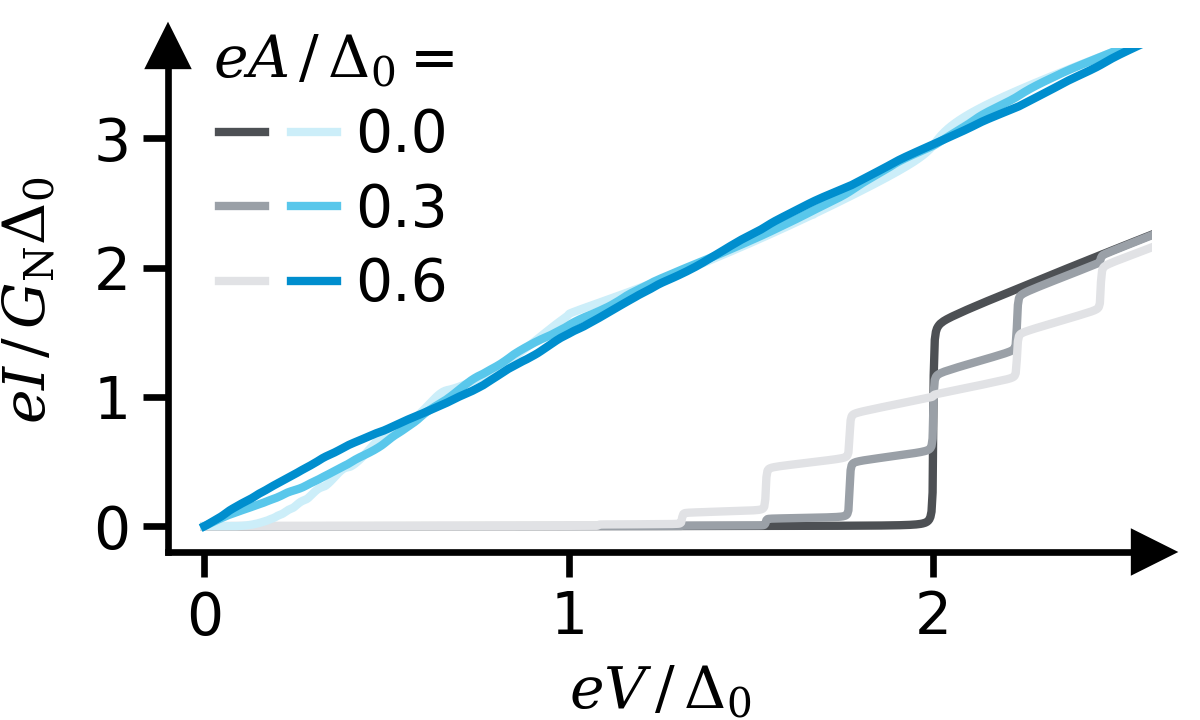

In [5]:
figsize = (2.0, 1.2)
fig, ax = sc.get_figure(figsize=figsize, subfigure=True)

for i, A in enumerate(A_bias_interest):
    ax.plot(
        V_bias[zero_mask],
        I_pat[idx[i], zero_mask],
        color=sc.seegrau[2 * i],
        zorder=i,
        label=f"$\\,$",
    )
for i, A in enumerate(A_bias_interest):
    y = I_pamar[idx[i], zero_mask]
    if A == 0.0:
        y = I_ha[zero_mask]
    ax.plot(
        V_bias[zero_mask],
        y,
        color=sc.seeblau[2 * (2 - i)],
        zorder=10 + i,
        label=f"{A:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 3.7)
ax.set_yticks([0, 1, 2, 3])
ax.set_xticks([0, 1, 2])

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.3,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)

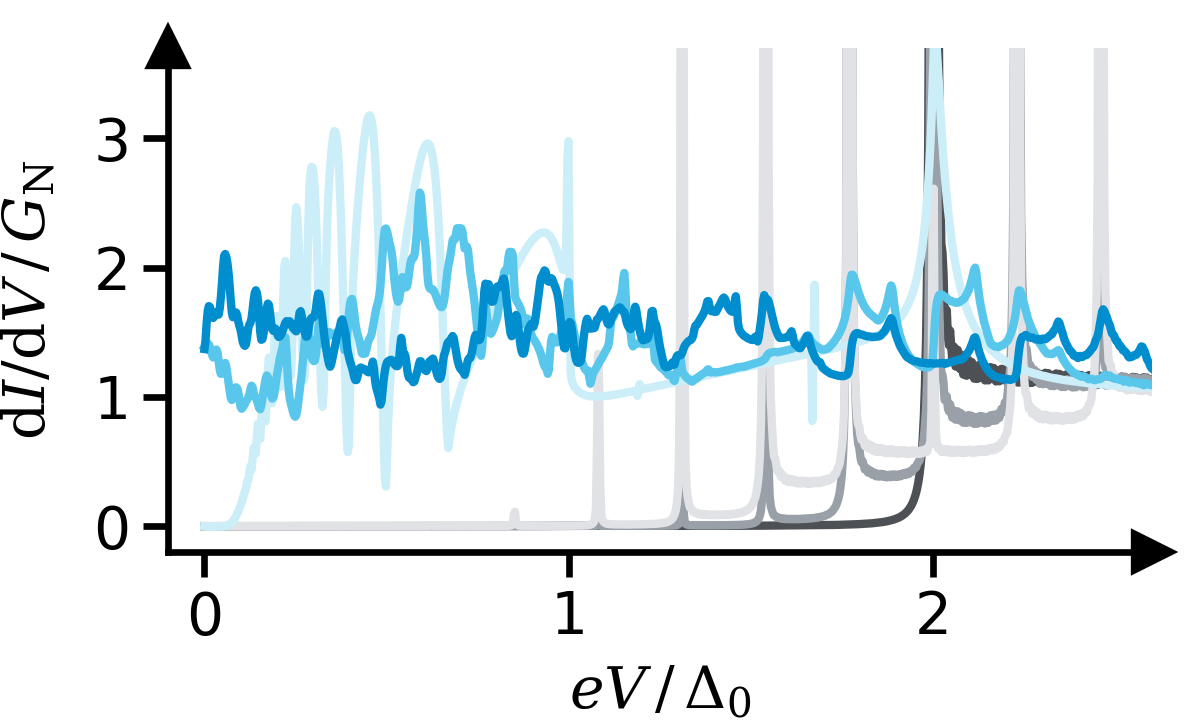

In [6]:
from numpy import zeros


figsize = (2.0, 1.2)
fig, ax = sc.get_figure(figsize=figsize, subfigure=True)

for i, A in enumerate(A_bias_interest):
    ax.plot(
        V_bias[zero_mask],
        dIdV_pat[idx[i], zero_mask],
        color=sc.seegrau[2 * i],
        zorder=i,
        label=f"$\\,$",
    )
for i, A in enumerate(A_bias_interest):
    y = dIdV_pamar[idx[i], zero_mask]
    if A == 0.0:
        y = dIdV_ha[zero_mask]
    ax.plot(
        V_bias[zero_mask],
        y,
        color=sc.seeblau[2 * (2 - i)],
        zorder=10 + i,
        label=f"{A:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 3.7)
ax.set_yticks([0, 1, 2, 3])
ax.set_xticks([0, 1, 2])

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$\\mathrm{d}I/\\mathrm{d}V\\,/\\,G_\\mathrm{N}$"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)

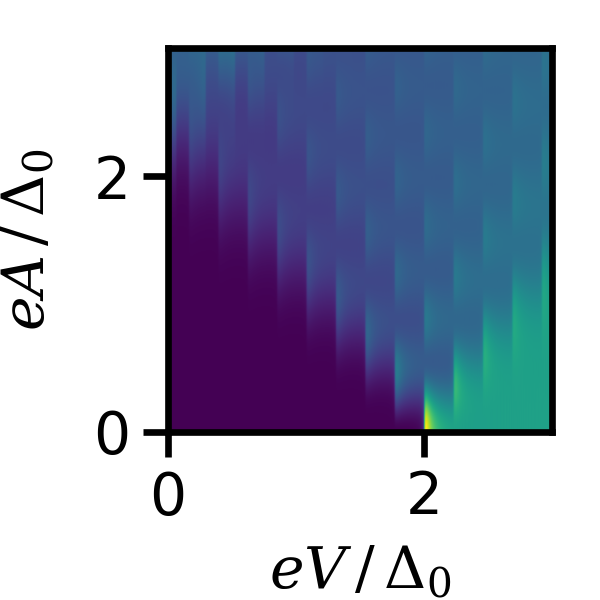

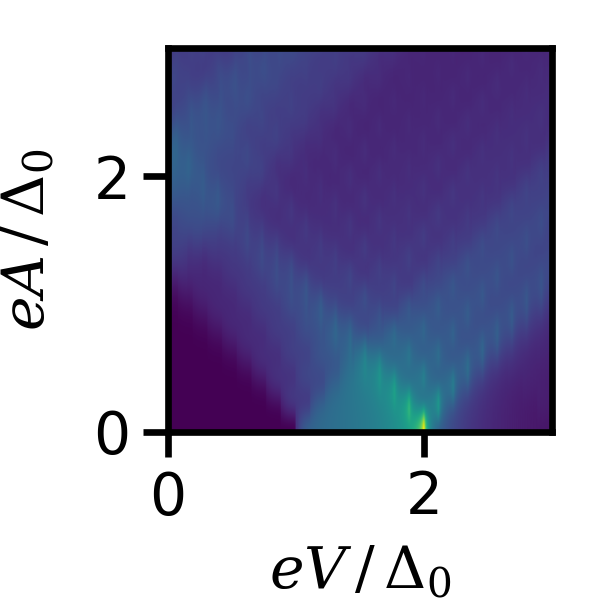

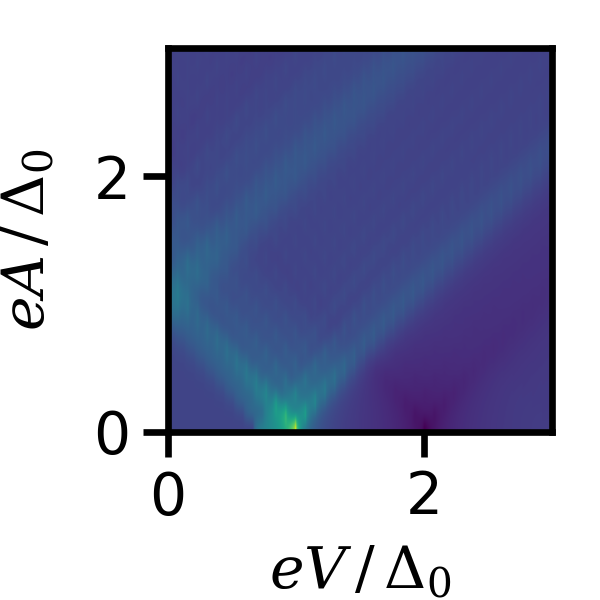

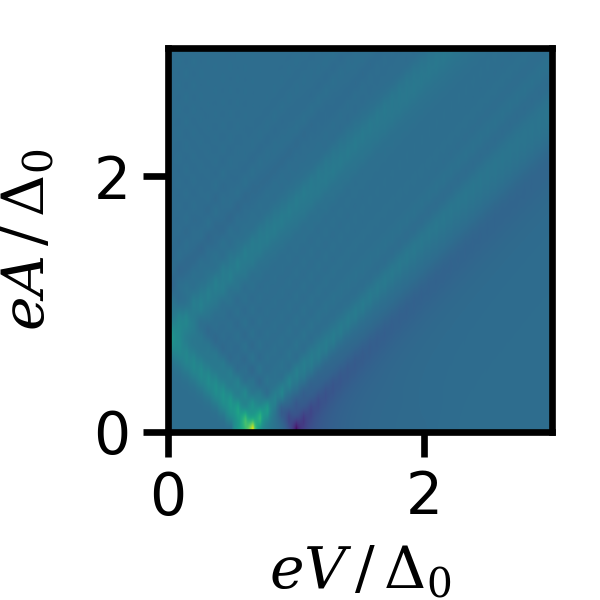

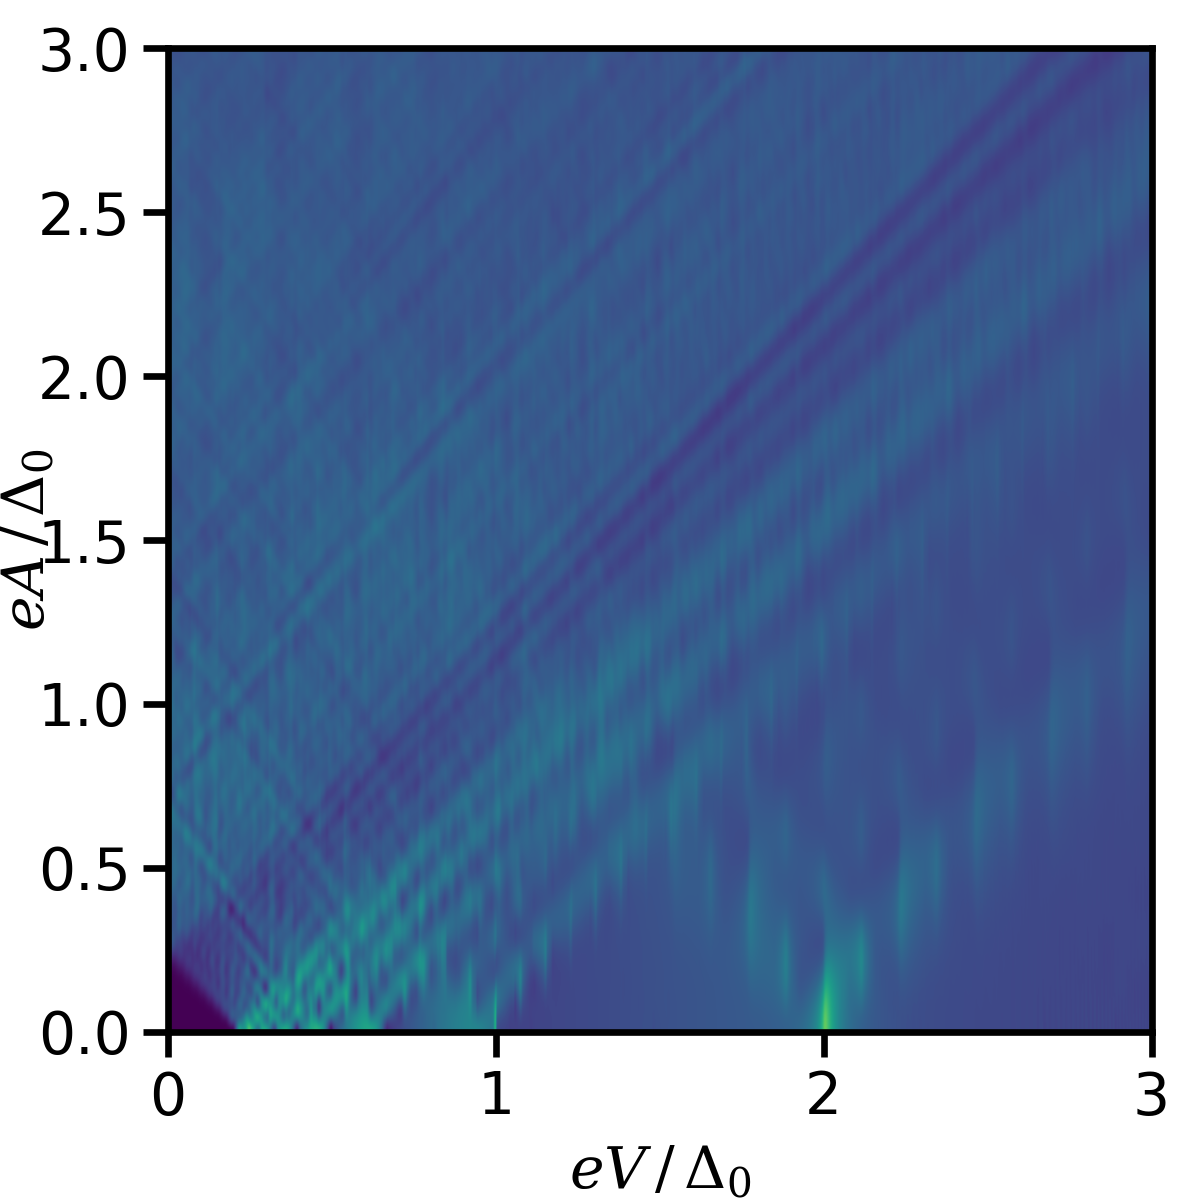

In [7]:
figsize = (1.0, 1.0)
clim = (-1, 3)
clim = (None, None)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eA\\,/\\,\\Delta_0$"

for i_m, m_i in enumerate(m[:4]):
    fig, ax = sc.get_figure(figsize=figsize, subfigure=True)
    ax.imshow(
        dIdV_pat_m[i_m, :, :],
        aspect="auto",
        origin="lower",
        extent=sc.get_ext(V_bias, A_bias),
        clim=clim,
    )
    ax.set_xlim(-0, None)
    title = None
    sc.map_layout(fig, ax, title, xlabel, ylabel)

fig, ax = sc.get_figure(figsize=(2.0, 2.0), subfigure=True)

ax.imshow(
    dIdV_pamar,
    aspect="auto",
    origin="lower",
    extent=sc.get_ext(V_bias, A_bias),
    clim=(0, 5),
)
ax.set_xlim(-0, None)
title = None
sc.map_layout(fig, ax, title, xlabel, ylabel)

# RSJ PAT + SS

In [8]:
tau = np.array([0.8, 0.1, 0.1])
# tau = np.array([0.66])
G_N = np.sum(tau)

V_bias = np.linspace(-3, 3, 2001)
I_bias = np.linspace(-10, 10, 10001) * G_N
A_bias = np.linspace(0, 3, 101)

Delta_meV = 0.180
T_K = 0.0
gamma_meV = 0.0
nu_GHz = 10.0

I_SW = 0.1
kappa = 0.1

V_bias_mV = V_bias * Delta_meV
A_bias_mV = A_bias * Delta_meV

I_rsj_nA = sc.get_I_rsj_nA(
    V_bias=V_bias,
    I_bias=I_bias,
    A_bias=A_bias,
    G_N=G_N,
    I_SW=I_SW,
    kappa=kappa,
    Delta_meV=Delta_meV,
    T_K=T_K,
    gamma_meV=gamma_meV,
    nu_GHz=nu_GHz,
)
dIdV_rsj = np.gradient(I_rsj_nA, V_bias_mV, axis=1) / G_0_muS

100%|██████████| 101/101 [01:10<00:00,  1.44it/s]


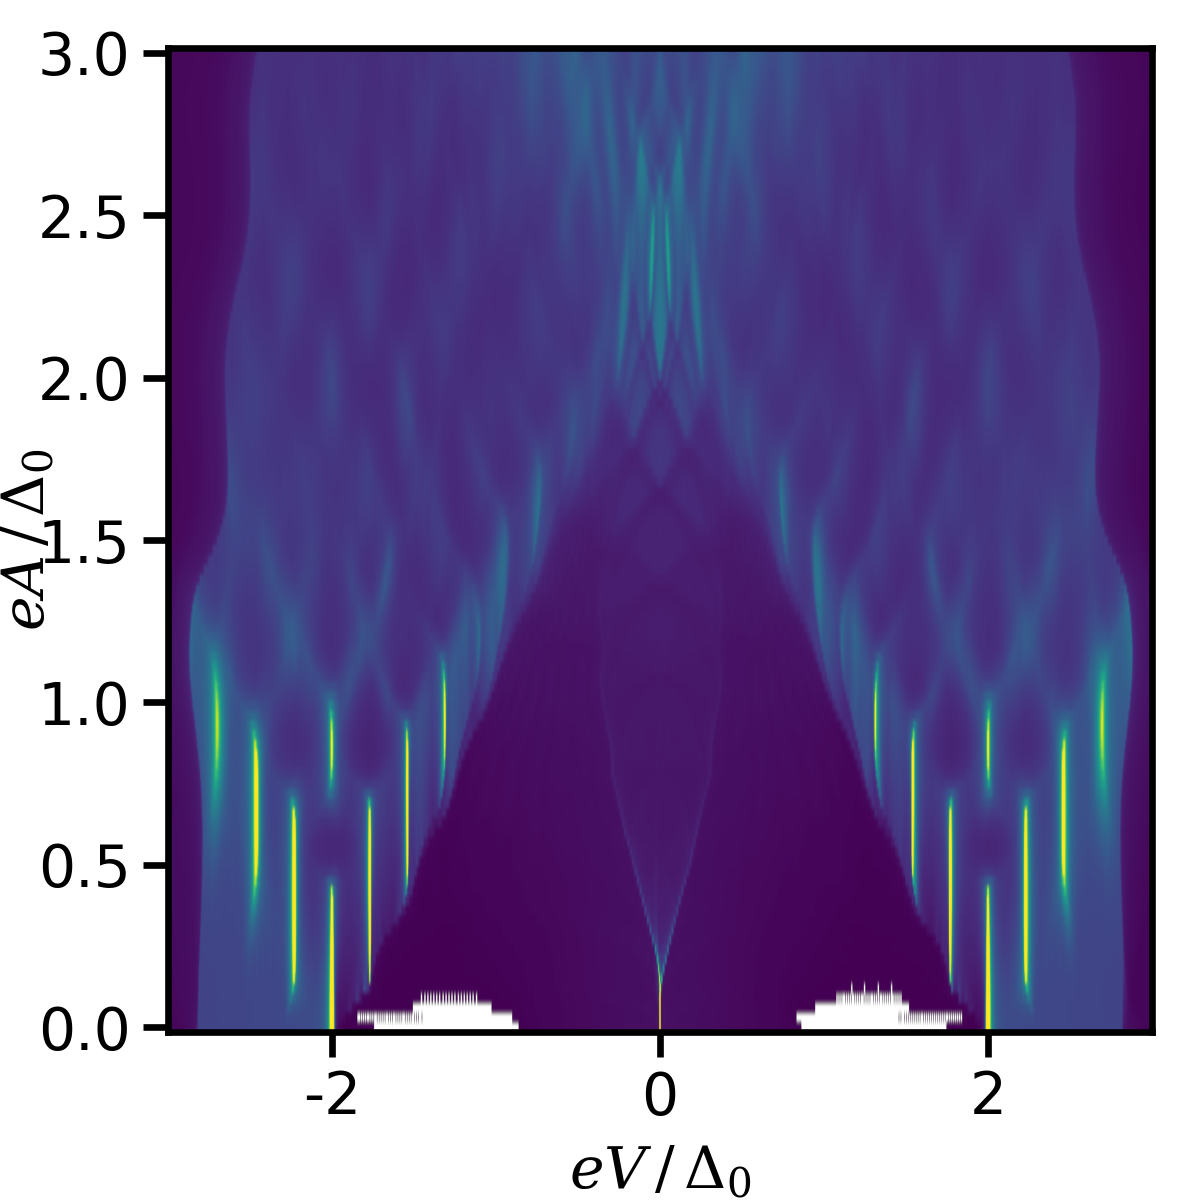

In [9]:
fig, ax = sc.get_figure(figsize=(2.0, 2.0), subfigure=True)

ax.imshow(
    dIdV_rsj,
    aspect="auto",
    origin="lower",
    extent=sc.get_ext(V_bias, A_bias),
    clim=(0, 5),
)
xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eA\\,/\\,\\Delta_0$"
title = None
sc.map_layout(fig, ax, title, xlabel, ylabel)

In [10]:
tau = np.array([0.8, 0.1, 0.1])
# tau = np.array([0.66])
G_N = np.sum(tau)

V_bias = np.linspace(-3, 3, 2001)
I_bias = np.linspace(-10, 10, 10001) * G_N
A_bias = np.linspace(0, 3, 101)

Delta_meV = 0.180
T_K = 0.0
gamma_meV = 0.0
nu_GHz = 10.0

I_SW = 0.1
kappa = 0.1

I_c_nA = sc.get_Ic_ab_nA(Delta_meV=Delta_meV, T_K=T_K)
I_p_nA = sc.get_I_p_abs_nA(
    tau=tau,
    Delta_meV=Delta_meV,
    T_K=T_K,
    p_max=10,
)
I_p_nA = np.array([])
# I_p_nA = I_SW * np.array([I_c_nA * 2 / 3, I_c_nA / 3])
# I_p_nA *= I_SW

V_bias_mV = V_bias * Delta_meV
A_bias_mV = A_bias * Delta_meV

I_rsj_meso_nA = sc.get_I_rsj_meso_nA(
    V_bias=V_bias,
    I_bias=I_bias,
    A_bias=A_bias,
    tau=tau,
    I_p_nA=I_p_nA,
    I_SW=I_SW,
    kappa=kappa,
    Delta_meV=Delta_meV,
    T_K=T_K,
    gamma_meV=gamma_meV,
    nu_GHz=nu_GHz,
    n_max=100,
)
dIdV_rsj_meso = np.gradient(I_rsj_meso_nA, V_bias_mV, axis=1) / G_0_muS

cached values: 1001/1001
cached values: 1001/1001
cached values: 1001/1001


100%|██████████| 101/101 [01:49<00:00,  1.08s/it]


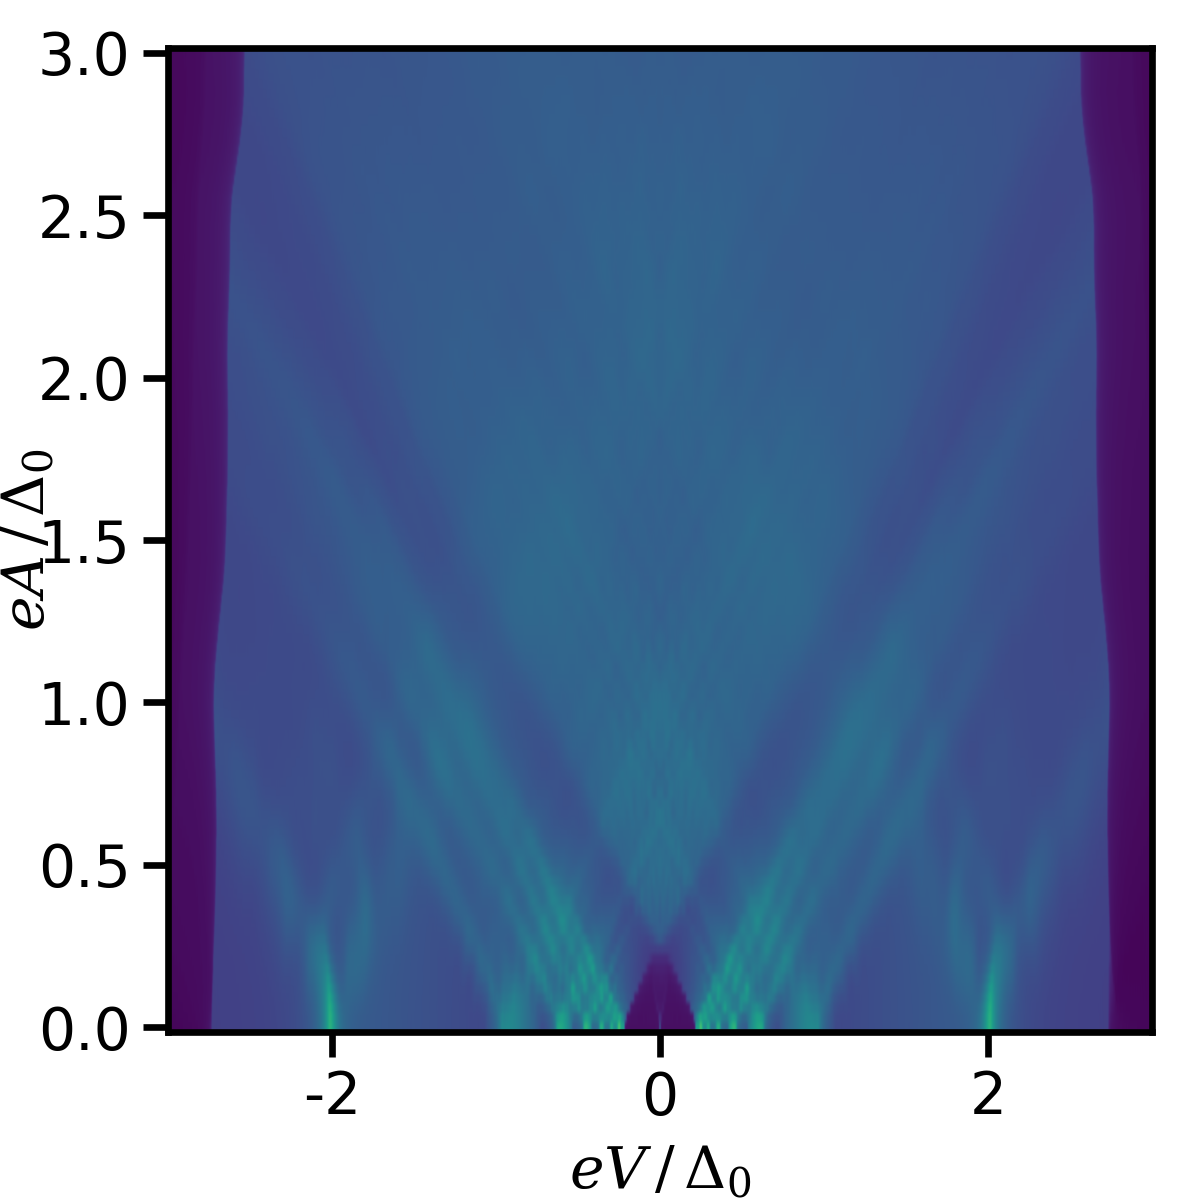

In [11]:
fig, ax = sc.get_figure(figsize=(2.0, 2.0), subfigure=True)

ax.imshow(
    dIdV_rsj_meso,
    aspect="auto",
    origin="lower",
    extent=sc.get_ext(V_bias, A_bias),
    clim=(0, 5),
)
xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eA\\,/\\,\\Delta_0$"
title = None
sc.map_layout(fig, ax, title, xlabel, ylabel)

# PAMAR via Area 
(Kot et al., Soerensen et al.)

In [12]:
A_bias = np.linspace(0, 3, 1001)
m = np.arange(0, 22, 1)
nu_GHz = 10.0

import matplotlib.pyplot as plt

mask_m = np.full((m.shape[0] - 1, V_bias.shape[0]), False, dtype=np.bool)
dIdV_pat_m = np.zeros((m.shape[0], A_bias.shape[0], V_bias.shape[0]))
for i_m, m_i in enumerate(m[1:]):

    mask_m[i_m, :] = np.logical_and(
        np.abs(V_bias) <= 2 / (m_i - 0.5),
        np.abs(V_bias) >= 2 / (m_i + 0.5),
    )

    dIdV_m = dIdV_ha * mask_m[i_m, :]
    dIdV_pat_m[i_m, :, :] = sc.get_I_pat_nA(
        V_mV=V_bias_mV,
        I_nA=dIdV_m,
        A_mV=A_bias_mV,
        nu_GHz=nu_GHz,
        m=m_i + 1,
    )
dIdV_pamar = np.sum(dIdV_pat_m, axis=0)

ValueError: could not broadcast input array from shape (101,2001) into shape (1001,2001)

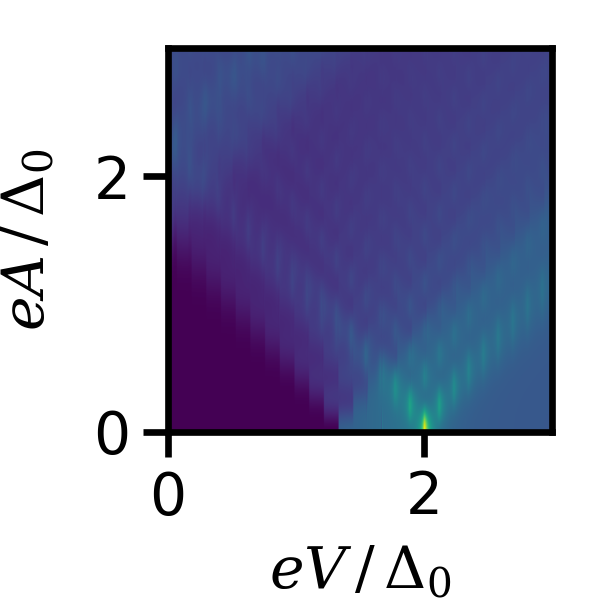

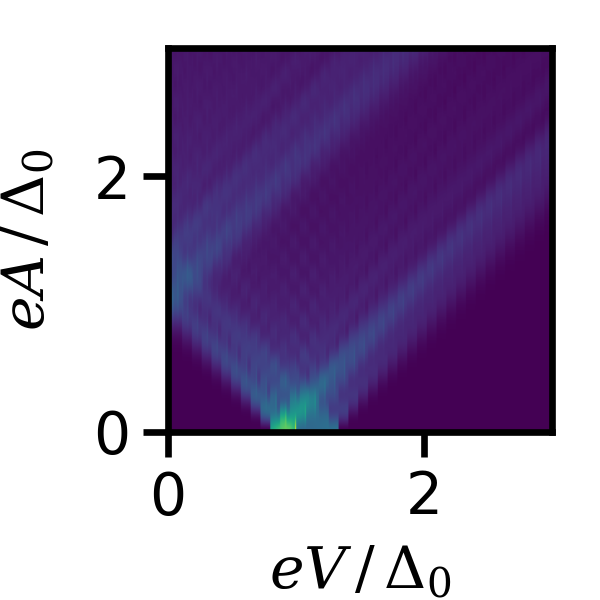

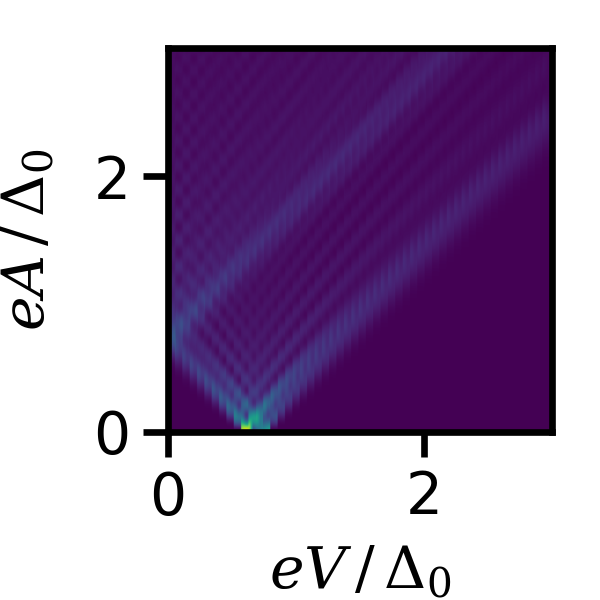

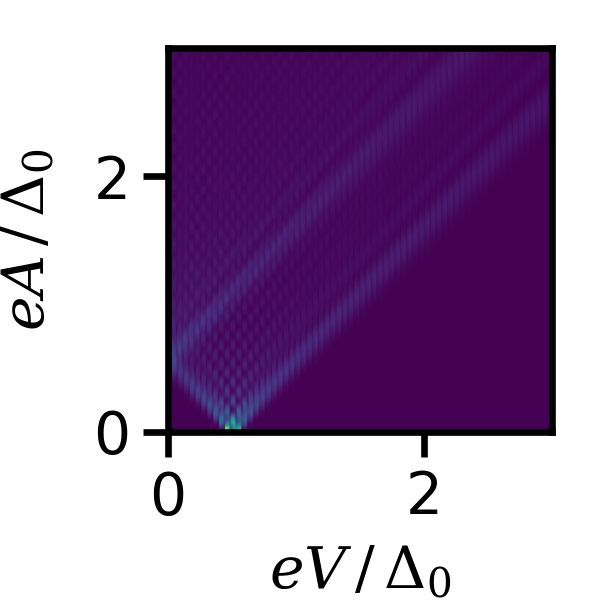

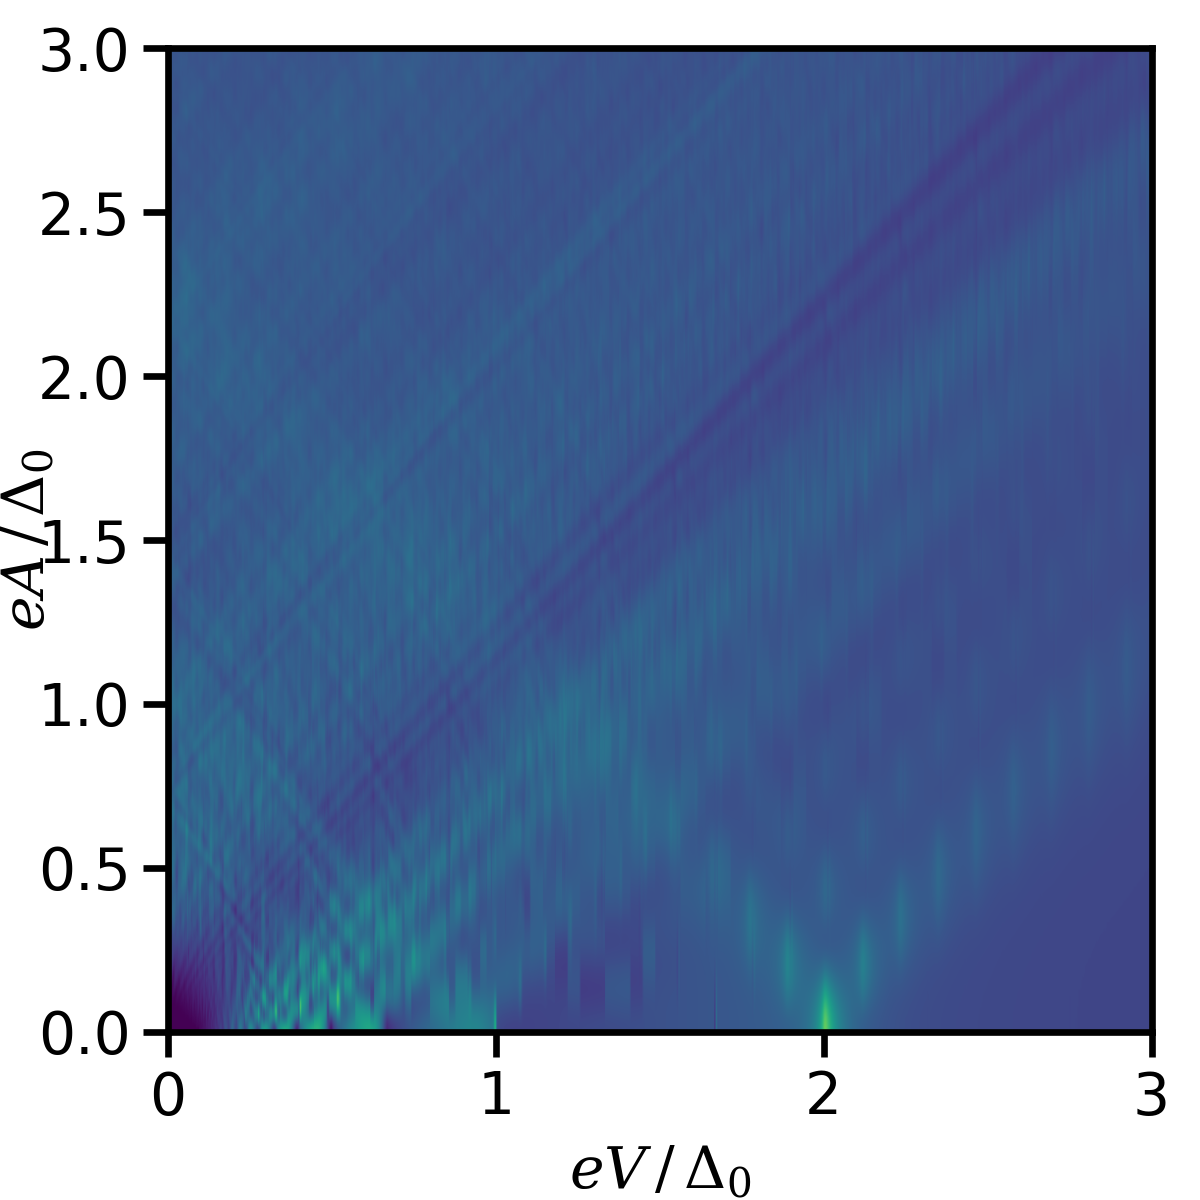

In [ ]:
figsize = (1.0, 1.0)
clim = (-1, 3)
clim = (None, None)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eA\\,/\\,\\Delta_0$"

for i_m, m_i in enumerate(m[:4]):
    fig, ax = sc.get_figure(figsize=figsize, subfigure=True)
    ax.imshow(
        dIdV_pat_m[i_m, :, :],
        aspect="auto",
        origin="lower",
        extent=sc.get_ext(V_bias, A_bias),
        clim=clim,
    )
    ax.set_xlim(-0, None)
    title = None
    sc.map_layout(fig, ax, title, xlabel, ylabel)

fig, ax = sc.get_figure(figsize=(2.0, 2.0), subfigure=True)

ax.imshow(
    dIdV_pamar,
    aspect="auto",
    origin="lower",
    extent=sc.get_ext(V_bias, A_bias),
    clim=(0, 5),
)
ax.set_xlim(-0, None)
title = None
sc.map_layout(fig, ax, title, xlabel, ylabel)

# RCSJ Model

In [ ]:
A_bias = np.linspace(0, 3, 1001)
m = np.arange(1, 11, 1)
nu_GHz = 10.0

A_bias_interest = [0, 0.3, 0.6]
idx = np.searchsorted(A_bias, A_bias_interest)

A_bias_mV = A_bias * Delta_meV
I_pat_m_nA = np.zeros((m.shape[0], A_bias.shape[0], V_bias.shape[0]))

for i_m, m_i in enumerate(m):
    I_fcs_m_nA = I_fcs_nA[:, i_m]
    I_pat_m_nA[i_m, :, :] = sc.get_I_pat_nA(
        V_mV=V_bias_mV,
        I_nA=I_fcs_m_nA,
        A_mV=A_bias_mV,
        nu_GHz=nu_GHz,
        m=m_i,
    )

I_pat_m = I_pat_m_nA / (G_0_muS * Delta_meV)
I_pamar = np.sum(I_pat_m, axis=0)

dIdV_pat_m = np.gradient(I_pat_m, V_bias, axis=2)
# dIdV_pat_m = np.where(dIdV_pat_m >= 0, dIdV_pat_m, 0.0)

dIdV_pamar = np.sum(dIdV_pat_m, axis=0)

I_pat_nA = sc.get_I_pat_nA(
    V_mV=V_bias_mV,
    I_nA=I_bcs_nA,
    A_mV=A_bias_mV,
    nu_GHz=nu_GHz,
    m=1,
)
I_pat = I_pat_nA / (G_0_muS * Delta_meV)
dIdV_pat = np.gradient(I_pat, V_bias, axis=1)

In [ ]:
from theory.models.pat_jax import get_I_nA as get_I_pat_nA
import numpy as np


def inv_gradient_axis_nonuniform_center0(g, x, axis=0):
    g = np.asarray(g, dtype=float)
    x = np.asarray(x, dtype=float)

    gT = np.moveaxis(g, axis, 0)  # (N, ...)
    dx = np.diff(x)  # (N-1,)

    # integrate from index 0 (arbitrary constant)
    fT = np.empty_like(gT)
    fT[0] = 0.0
    fT[1:] = np.cumsum(0.5 * (gT[1:] + gT[:-1]) * dx[:, None, None], axis=0)

    # choose the index where x is closest to 0 and enforce f(x0)=0
    i0 = int(np.argmin(np.abs(x)))
    fT = fT - fT[i0]  # broadcasts over remaining dims

    return np.moveaxis(fT, 0, axis)


A_bias = np.linspace(0, 3, 1001)
m = np.arange(1, 10, 1)
nu_GHz = 10.0

A_bias_interest = [0, 0.3, 0.6]
idx = np.searchsorted(A_bias, A_bias_interest)

A_bias_mV = A_bias * Delta_meV
dIdV_pat_m_nA = np.zeros((m.shape[0], A_bias.shape[0], V_bias.shape[0]))
I_pat_m = np.zeros((m.shape[0], A_bias.shape[0], V_bias.shape[0]))

dIdV_fcs_pos = np.where(dIdV_fcs > 0, dIdV_fcs, 0.0)
dIdV_fcs_neg = np.where(dIdV_fcs < 0, dIdV_fcs, 0.0)

for i_m, m_i in enumerate(m):
    dIdV_fcs_m = dIdV_fcs_pos[:, i_m]
    dIdV_fcs_m += dIdV_fcs_neg[:, i_m]
    dIdV_pat_m[i_m, :, :] = get_I_pat_nA(
        V_mV=V_bias_mV,
        I_nA=dIdV_fcs_m,
        A_mV=A_bias_mV,
        nu_GHz=nu_GHz,
        m=m_i,
    )
I_pat_m = inv_gradient_axis_nonuniform_center0(dIdV_pat_m, V_bias, axis=2)
I_pat_m_nA = I_pat_m * G_0_muS * Delta_meV

I_pamar = np.sum(I_pat_m, axis=0)
I_pamar_nA = np.sum(I_pat_m_nA, axis=0)
dIdV_pamar = np.sum(dIdV_pat_m, axis=0)

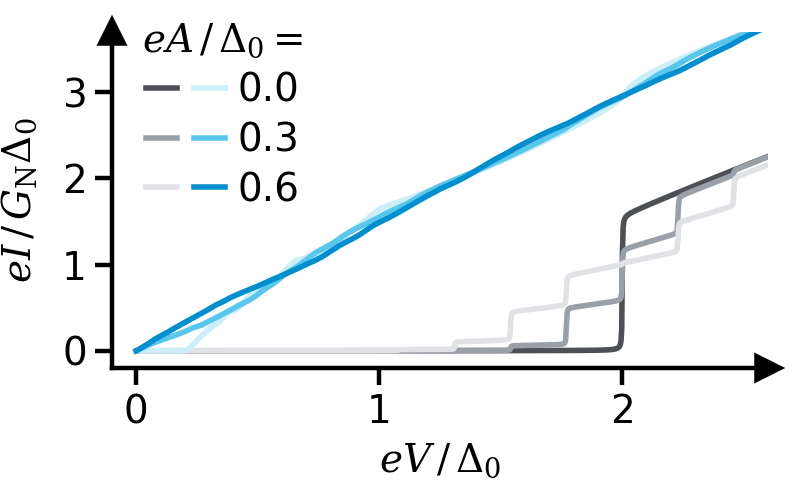

In [ ]:
figsize = (2.0, 1.2)
fig, ax = get_figure(figsize=figsize, subfigure=True)

for i, A in enumerate(A_bias_interest):
    ax.plot(
        V_bias[zero_mask],
        I_pat[idx[i], zero_mask],
        color=seegrau[2 * i],
        zorder=i,
        label=f"$\\,$",
    )
for i, A in enumerate(A_bias_interest):
    ax.plot(
        V_bias[zero_mask],
        I_pamar[idx[i], zero_mask],
        color=seeblau[2 * (2 - i)],
        zorder=10 + i,
        label=f"{A:1.1f}",
    )

ax.set_xlim(-0.1, 2.6)
ax.set_ylim(-0.2, 3.7)
ax.set_yticks([0, 1, 2, 3])
ax.set_xticks([0, 1, 2])

ax.legend(
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.3,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = "pamar-iv"

theory_layout(fig, ax, title, xlabel, ylabel)

TypeError: theory_layout() got an unexpected keyword argument 'padding'

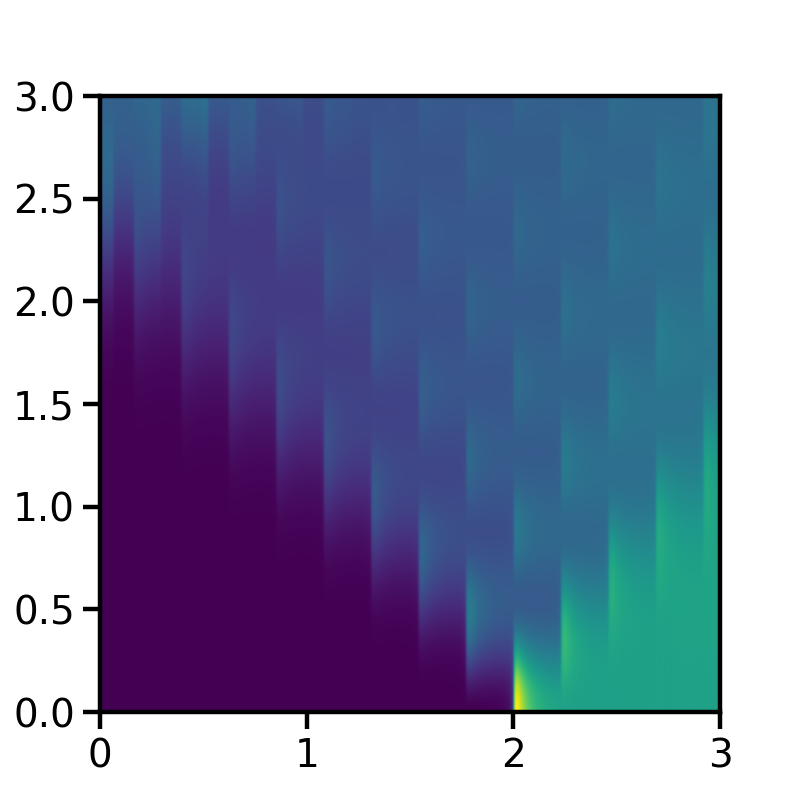

In [ ]:
figsize = (2.0, 2.0)
extent = (np.min(V_bias), np.max(V_bias), np.min(A_bias), np.max(A_bias))
clim = (-1, 3)
clim = (None, None)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eA\\,/\\,\\Delta_0$"
title = None

for i_m, m_i in enumerate(m):
    fig, ax = get_figure(figsize=figsize, subfigure=True)
    ax.imshow(
        dIdV_pat_m[i_m, :, :], aspect="auto", origin="lower", extent=extent, clim=clim
    )
    ax.set_xlim(-0, None)
    theory_layout(fig, ax, title, xlabel, ylabel, padding=(0.3, 0.3))

fig, ax = get_figure(figsize=figsize, subfigure=True)
ax.imshow(dIdV_pamar, aspect="auto", origin="lower", extent=extent, clim=clim)
ax.set_xlim(-0, None)
theory_layout(fig, ax, title, xlabel, ylabel, padding=(0.3, 0.3))

# tunnel junction (RSJ)

In [ ]:
# definitions
G_N = 1.0

V_bias = np.linspace(-4.5, 4.5, 1501)
I_bias = np.linspace(-10, 10, 10001) * G_N
A_bias = np.linspace(0, 1, 101)
# A_bias = np.array([0.6])

Delta_meV = 0.180
T_K = 0.1
gamma_meV = 0.0
nu_GHz = 10.0

I_SW = 0.15
kappa = 1

n_max = 100

I_rsj_nA = get_I_rsj_nA(
    V_bias=V_bias,
    I_bias=I_bias,
    A_bias=A_bias,
    G_N=G_N,
    I_SW=I_SW,
    kappa=kappa,
    Delta_meV=Delta_meV,
    T_K=T_K,
    gamma_meV=gamma_meV,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_rsj = I_rsj_nA / (G_0_muS * Delta_meV)
dIdV_rsj = np.gradient(I_rsj, V_bias, axis=1)

In [ ]:

i_a = 20 # plotter

len_a = A_bias.shape[0]
if i_a >= len_a:
    i_a =len_a-1

%matplotlib qt
plt.close("all")
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $G_N={G_N}$")
plt.plot(V_bias, I_rsj[i_a,:], "r-", label=r"$I_\mathrm{MW}(V)$")
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"$eI\,/\,G_0\Delta_0$")
plt.legend()
plt.grid(True)

plt.figure()
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $G_N={G_N}$")
plt.plot(V_bias, dIdV_rsj[i_a,:], "r-", label=r"$I_\mathrm{rsj}(V)$")
plt.ylim(-.1*G_N, 4.1*G_N)
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"d$I$d$V\,/\,G_0$")
plt.legend()
plt.grid(True)

if len_a > 1:
    extent = (np.min(V_bias), np.max(V_bias), np.min(A_bias), np.max(A_bias))

    plt.figure()
    plt.title(f"RSJ, $I_s={I_SW}$, $\\kappa={kappa}$, $G_N={G_N}$")
    plt.imshow(dIdV_rsj, aspect='auto', origin='lower', clim=(0, G_N*2), extent=extent,)
    plt.hlines(y = A_bias[i_a], xmin = extent[0], xmax=extent[1], color='red')
    plt.xlabel(r"$eV\,/\,\Delta_0$")
    plt.ylabel(r"$eA\,/\,\Delta_0$")

# fSS + PAMAR

In [ ]:
# definitions
tau = np.array([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.3, 0.1])
G_N = np.sum(tau)

Delta_meV = 0.180
T_K = 0.0
gamma_meV = 1e-3
nu_GHz = 10.0

I_SW = 1
kappa = 1

V_bias = np.linspace(-4.5, 4.5, 1501)
I_bias = np.linspace(-10, 10, 10001) * G_N
A_bias = np.linspace(0, 4, 101)

meso = True
if not meso:
    G_N = 1.0

In [ ]:
# pre-calculating SC

I_C = get_IC_AB(Delta_meV=Delta_meV, T_K=T_K)
I_p = get_I_p(
    tau=tau,
    Delta_meV=Delta_meV,
    T_K=T_K,
    p_max=10,
)
I_p_fss = I_SW * I_p

I_p_ss = I_SW * np.array([I_C])
I_p_fss = I_SW * np.array([2 * I_C / 3, I_C / 3])

In [ ]:
# technical stuff

V_bias_mV = V_bias * Delta_meV
A_bias_mV = A_bias * Delta_meV
I_bias_nA = I_bias * G_0_muS * Delta_meV
A_bias_nA = A_bias * G_0_muS * Delta_meV

A_bias_nA *= kappa * G_N

n_max = 100
p_max = 10
m_max = 11

In [ ]:
# pre-calculation QP

# tunnel junction
I_BCS_nA = get_I_nA_bcs(
    V_mV=V_bias_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_PAT_nA = get_I_nA_tg(
    A_mV=A_bias_mV,
    V_mV=V_bias_mV,
    I_nA=I_BCS_nA,
    nu_GHz=nu_GHz,
)

I_BCS = I_BCS_nA / (G_0_muS * Delta_meV)
I_PAT = I_PAT_nA / (G_0_muS * Delta_meV)
dIdV_BCS = np.gradient(I_BCS_nA, V_bias_mV) / G_0_muS
dIdV_PAT = np.gradient(I_PAT_nA, V_bias_mV, axis=1) / G_0_muS

# weak link
I_FCS_nA = np.zeros((tau.shape[0], V_bias.shape[0], m_max))
for i_tau, tau_i in enumerate(tau):
    I_FCS_nA[i_tau, :, :] = get_I_nA_fcs(
        V_mV=V_bias_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
    )
I_FCS_nA = np.sum(I_FCS_nA, axis=0)
I_PAMAR_nA = get_I_nA_utg(
    V_mV=V_bias_mV,
    A_mV=A_bias_mV,
    I_nA=I_FCS_nA,
    nu_GHz=nu_GHz,
)
I_PAMAR_nA = np.sum(I_PAMAR_nA[:, :, 1:], axis=2)
I_FCS_nA = np.sum(I_FCS_nA[:, 1:], axis=1)

I_FCS = I_FCS_nA / (G_0_muS * Delta_meV)
I_PAMAR = I_PAMAR_nA / (G_0_muS * Delta_meV)

dIdV_FCS = np.gradient(I_FCS, V_bias)
dIdV_PAMAR = np.gradient(I_PAMAR, V_bias, axis=1)

In [ ]:
# caser
if meso:
    I_QP_nA = I_PAMAR_nA
    I_p = I_p_fss
else:
    I_QP_nA = I_PAT_nA
    I_p = I_p_ss

I_QP = I_QP_nA / (G_0_muS * Delta_meV)
dIdV_QP = np.gradient(I_QP_nA, V_bias_mV, axis=1) / G_0_muS

I_p_nA = I_p * G_0_muS * Delta_meV
print(I_p)

In [ ]:
# QP Interpolator
import jax.numpy as jnp

interp_V_QP_mV: list[Callable[[jnp.ndarray], jnp.ndarray]] = []

V_QP_mV = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)
for i, a_bias_mV in enumerate(tqdm(A_bias_mV)):

    I_QP_nA_over, V_bias_mV_over = oversample(I_QP_nA[i, :], V_bias_mV)
    v_QP_mV = bin_y_over_x(I_QP_nA_over, V_bias_mV_over, I_bias_nA)
    V_QP_mV[i, :] = v_QP_mV

    interp_V_QP_mV.append(
        make_interp_V_QP_mV(
            I_bias_nA=I_bias_nA,
            V_QP_mV=v_QP_mV,
            G_N=G_N,
        )
    )
V_QP = V_QP_mV / Delta_meV

In [ ]:
# da heavy shit
I_mw_nA = np.full((A_bias_mV.shape[0], V_bias_mV.shape[0]), np.nan)
V_mw_mV = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)

for i, a_bias_nA in enumerate(tqdm(A_bias_nA)):
    v_mv_mV = sim_V_RSJ_mV_jax(
        I_bias_nA=I_bias_nA,
        A_bias_nA=a_bias_nA,
        interp_V_QP_mV=interp_V_QP_mV[i],
        I_p_nA=I_p_nA,
        nu_GHz=nu_GHz,
        n_periods_total=10,
        n_periods_discard=1,
        n_steps_per_period=200,
    )[0, :]
    v_mv_mV_over, I_bias_nA_over = oversample(v_mv_mV, I_bias_nA, upsample=100)
    i_mw_nA = bin_y_over_x(v_mv_mV_over, I_bias_nA_over, V_bias_mV)

    I_mw_nA[i, :] = i_mw_nA
    V_mw_mV[i, :] = v_mv_mV

V_mw = V_mw_mV / Delta_meV
I_mw = I_mw_nA / (G_0_muS * Delta_meV)
dIdV_mw = np.gradient(I_mw_nA, V_bias_mV, axis=1) / G_0_muS

In [ ]:
# calculation SC

# tunnel junction
I_SS = do_I_fSS(
    V_mV=V_bias_mV,
    A_mV=A_bias_nA / G_0_muS,
    I=I_p_ss,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_SS_nA = I_SS * G_0_muS * Delta_meV

# weak link
I_fSS = do_I_fSS(
    V_mV=V_bias_mV,
    A_mV=A_bias_nA / G_0_muS,
    I=I_p_fss,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_fSS_nA = I_fSS * G_0_muS * Delta_meV

In [ ]:
i_a = 20
clim = (0, G_N * 3)

In [ ]:
# plotter

%matplotlib qt

plt.close("all")
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $\\tau={tau}$")
if meso:
    plt.plot(V_bias, I_PAMAR[i_a,:]+I_fSS[i_a,:], 
            V_bias, I_PAMAR[i_a,:]-I_fSS[i_a,:], 
            "-", color='grey', label=r"$I_\mathrm{PAMAR+fSS}(V)$",)
else:
    plt.plot(V_bias, I_PAT[i_a,:]+I_SS[i_a,:], 
            V_bias, I_PAT[i_a,:]-I_SS[i_a,:], 
            "-", color='lightgrey', label=r"$I_\mathrm{PAT+SS}(V)$",)
plt.plot(V_bias, I_QP[i_a,:], '-', color='grey', label=r"$I_\mathrm{QP}(V)$")
plt.plot(V_QP[i_a,:], I_bias, "x", color='grey', label=r"$I(V_\mathrm{QP})$")

plt.plot(V_mw[i_a,:], I_bias, "rx", label=r"$I(V_\mathrm{rsj})$")
plt.plot(V_bias, I_mw[i_a,:], "r-", label=r"$I_\mathrm{MW}(V)$")
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"$eI\,/\,G_0\Delta_0$")
plt.legend()
plt.grid(True)

plt.figure()
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $\\tau={tau}$")
if meso:
    plt.plot(V_bias, dIdV_PAMAR[i_a,:]+I_fSS[i_a,:], "-", color='grey', label=r"$I_\mathrm{PAMAR+fSS}(V)$")
else:
    plt.plot(V_bias, dIdV_PAT[i_a,:]+I_SS[i_a,:], "-", color="lightgrey", label=r"$I_\mathrm{PAT+SS}(V)$")
plt.plot(V_bias, dIdV_mw[i_a,:], "r-", label=r"$I_\mathrm{rsj}(V)$")
plt.ylim(-1+clim[0], 2*clim[1]+1)
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"d$I$d$V\,/\,G_0$")
plt.legend()
plt.grid(True)

extent = (np.min(V_bias), np.max(V_bias), np.min(A_bias), np.max(A_bias))
if meso:
    plt.figure()
    plt.title(f"PAMAR")
    plt.imshow(dIdV_PAMAR+I_fSS, aspect='auto', origin='lower', clim=clim, extent=extent,)
    plt.xlabel(r"$eV\,/\,\Delta_0$")
    plt.ylabel(r"$eA\,/\,\Delta_0$")
else:
    plt.figure()
    plt.title(f"PAT")
    plt.imshow(dIdV_PAT+I_SS, aspect='auto', origin='lower', clim=clim, extent=extent,)
    plt.xlabel(r"$eV\,/\,\Delta_0$")
    plt.ylabel(r"$eA\,/\,\Delta_0$")

plt.figure()
plt.title(f"RSJ")
plt.imshow(dIdV_mw, aspect='auto', origin='lower', clim=clim, extent=extent,)
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"$eA\,/\,\Delta_0$")

In [ ]:
# test interpolator
V_test_mV = I_bias_nA / (G_N * G_0_muS * Delta_meV)
V_test = V_test_mV / Delta_meV

V_iQP_mV = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)
I_iQP_nA = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)

for i, a_bias_mV in enumerate(tqdm(A_bias_mV)):
    v_iQP_mV = np.array(interp_V_QP_mV[i](jnp.array(I_bias_nA)))

    v_iQP_mV_over, I_bias_nA_over = oversample(v_iQP_mV, I_bias_nA)
    i_iQP_nA = bin_y_over_x(v_iQP_mV_over, I_bias_nA_over, V_test_mV)

    I_iQP_nA[i, :] = i_iQP_nA
    V_iQP_mV[i, :] = v_iQP_mV

V_iQP = V_iQP_mV / Delta_meV
I_iQP = I_iQP_nA / (G_0_muS * Delta_meV)
dIdV_iQP = np.gradient(I_iQP, V_test, axis=1)

In [ ]:
# plot interpolator
%matplotlib qt

i_a = 60
plt.close("all")
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $\\tau={tau}$")
plt.plot(V_bias, I_PAT[i_a,:], 
         V_bias, I_PAT[i_a,:], 
         "-", color='lightgrey', label=r"$I_\mathrm{PAT+SS}(V)$",)
plt.plot(V_bias, I_PAMAR[i_a,:], 
         V_bias, I_PAMAR[i_a,:], 
         "-", color='grey', label=r"$I_\mathrm{PAMAR+fSS}(V)$",)
plt.plot(V_bias, I_QP[i_a,:], '-', color='grey', label=r"$I_\mathrm{QP}(V)$")
plt.plot(V_QP[i_a,:], I_bias, "x", color='grey', label=r"$I(V_\mathrm{QP})$")

plt.plot(V_iQP[i_a,:], I_bias, "x", color='green', label=r"$I(V_\mathrm{iQP})$")
plt.plot(V_test, I_iQP[i_a,:], "-", color='green', label=r"$I_\mathrm{iQP}(V)$")

# ABS Stuff

In [ ]:
Delta_meV = 0.180
T_K = 0.0

tau = np.array([1.0, 0.95, 0.66, 0.33, 0.1])
phi = np.linspace(0, 2 * np.pi, 361)

E_abs = np.zeros((tau.shape[0], phi.shape[0]))
E_abs_meV = np.copy(E_abs)
I_abs = np.copy(E_abs)
I_abs_nA = np.copy(E_abs)

for i_tau, tau_i in enumerate(tau):
    E_abs[i_tau, :] = get_E_ABS(
        phi=phi,
        tau=tau_i,
    )
    I_abs[i_tau, :] = get_CPR_ABS(
        phi=phi,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
    )

In [ ]:
fig, ax = get_figure(figsize=(2, 1.2), subfigure=True)
for i, tau_i in enumerate(tau):
    plt.plot(phi / (np.pi), I_abs[i, :] / tau_i, ".", color=seeblau[i])

ax.set_xticks([0, 1, 2])
ax.set_ylim(-3.3, 3.8)

ylabel = "$eI / \\tau G_0 |\\Delta|$"
xlabel = "$\\phi$ ($\\pi$)"
title = "abs-Iphi"

theory_layout(fig, ax, title, xlabel, ylabel)

In [ ]:
fig, ax = get_figure(figsize=(2, 1.2), subfigure=True)
for i, tau_i in enumerate(tau):
    ax.plot(phi / (np.pi), E_abs[i, :], color=seeblau[i])
    ax.plot(phi / (np.pi), -E_abs[i, :], color=seeblau[i])

ax.set_xticks([0, 1, 2])
ax.set_ylim(-1.1, 1.25)

ylabel = "$E_\\pm(\\phi)/|\\Delta|$"
xlabel = "$\\phi$ ($\\pi$)"
title = "abs-Ephi"

theory_layout(fig, ax, title, xlabel, ylabel)

# Multichannel Contact

In [ ]:
tau = np.linspace(0, 1, 101)
phi = np.linspace(0, 1, 101)
phi *= 2 * np.pi

G_N = 0.9
T_K = 0.0
n_phi = 501

rho = get_rho(tau=tau, G_N=G_N)
CPR_AB = get_CPR_AB(phi=phi, Delta_meV=Delta_meV, G_N=G_N, T_K=T_K)
CPR_ABS = get_CPR_ABS(phi=phi, Delta_meV=Delta_meV, tau=G_N, T_K=T_K)
CPR_KO2 = get_CPR_KO2(phi=phi, Delta_meV=Delta_meV, G_N=G_N, T_K=T_K)
CPR_KO1 = get_CPR_KO1(phi=phi, Delta_meV=Delta_meV, G_N=G_N, T_K=T_K)

TC_K = T_C_K_of_Delta_meV(Delta_meV=Delta_meV)
T = np.linspace(0, 1, 101)
T_K = T * TC_K

I_C_AB = get_ICT_AB(T_K=T_K, Delta_meV=Delta_meV, G_N=G_N)
I_C_ABS = get_ICT_ABS(T_K=T_K, Delta_meV=Delta_meV, tau=G_N, n_phi=n_phi)
I_C_KO1 = get_ICT_KO1(T_K=T_K, Delta_meV=Delta_meV, G_N=G_N, n_phi=n_phi)
I_C_KO2 = get_ICT_KO2(T_K=T_K, Delta_meV=Delta_meV, G_N=G_N, n_phi=n_phi)

In [ ]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(phi / (2 * np.pi), CPR_AB, color=seegrau65, label="AB")
ax.plot(phi / (2 * np.pi), CPR_KO1, color=seeblau65, label="KO1")
ax.plot(phi / (2 * np.pi), CPR_KO2, color=seeblau100, label="KO2")

ax.set_xlim(-0.05, 1.15)
ax.set_xticks([0, 1])

ylabel = "$eI\\,/\\,G_N \\Delta$"
xlabel = "$\\phi\\,/\\,2\\pi$"
title = "ko-cpr"

theory_layout(fig, ax, title, xlabel, ylabel)

In [ ]:
fig, ax = get_figure(figsize=(2.0, 1.2), subfigure=True)

ax.plot(T, I_C_AB, color=seegrau65, label="AB")
ax.plot(T, I_C_KO1, color=seeblau65, label="KO1")
ax.plot(T, I_C_KO2, color=seeblau100, label="KO2")

ax.legend()
ax.set_xlim(-0.05, 1.15)
ax.set_xticks([0, 1])
ax.set_ylim(-0.2, 3.6)
ax.set_yticks([0, np.pi / 2, np.pi], labels=["0", "$\\frac{\\pi}{2}$", "$\\pi$"])

ax.legend(
    handlelength=1.0,
    loc="upper right",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=1,
    columnspacing=1.0,
    bbox_to_anchor=(1.0, 1.1),
)

ylabel = "$eI_\\mathrm{C}\\,/\\,G_N \\Delta$"
xlabel = "$T\\,/\\,T_\\mathrm{C}$"
title = "ko-ic"

theory_layout(fig, ax, title, xlabel, ylabel)

In [ ]:
fig, ax = get_figure(figsize=(1.2, 1.0), subfigure=True)

ax.plot(tau, rho, color=seeblau100)

ax.set_ylim(0, 12)
ax.set_yticks([0, 5, 10])
ax.set_xlim(-0.05, 1.15)
ax.set_xticks([0, 1])

ylabel = "$\\rho(\\tau)$"
xlabel = "$\\tau$"
title = "ko-rho"

theory_layout(fig, ax, title, xlabel, ylabel)

# fractional Shapiro Peaks

In [ ]:
V = np.linspace(-3, 3, 1001)
A = np.array([0, 0.3, 0.6])
A = np.array([0.8])

Delta_meV = 0.180
V_mV = V * Delta_meV
A_mV = A * Delta_meV

T_K = 0.0
gamma_meV = 1e-4
nu_GHz = 20.0

tau = np.array([0.8, 0.3, 0.1])
G_N = np.sum(tau)

m_max = 11
n_max, p_max = 1000, 10

# PAT + SS
I_SS_nA = get_I_SS_nA(
    V_mV=V_mV,
    A_mV=A_mV,
    G_N=G_N,
    Delta_meV=Delta_meV,
    T_K=T_K,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_BCS_nA = get_I_nA_bcs(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_PAT_nA = np.empty((A_mV.shape[0], V_mV.shape[0]))
for i, a_mV in enumerate(A_mV):
    I_PAT_nA[i, :] = get_I_nA_tg(A_mV=a_mV, V_mV=V_mV, I_nA=I_BCS_nA, nu_GHz=nu_GHz)
dIdV_PAT = np.gradient(I_PAT_nA, V_mV, axis=1) / G_0_muS

# PAMAR + fSS
I_fSS_nA = get_I_fSS_nA(
    V_mV=V_mV,
    A_mV=A_mV,
    tau=tau,
    Delta_meV=Delta_meV,
    T_K=T_K,
    nu_GHz=nu_GHz,
    n_max=n_max,
    p_max=p_max,
)

I_FCS_nA = np.zeros((tau.shape[0], V.shape[0], m_max))
for i_tau, tau_i in enumerate(tau):
    I_FCS_nA[i_tau, :, :] = get_I_nA_fcs(
        V_mV=V_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
    )
I_FCS_nA = np.sum(I_FCS_nA, axis=0)
I_PAMAR_nA = get_I_nA_utg(
    V_mV=V_mV,
    A_mV=A_mV,
    I_nA=I_FCS_nA,
    nu_GHz=nu_GHz,
)
I_PAMAR_nA = np.sum(I_PAMAR_nA, axis=2)
dIdV_PAMAR = np.gradient(I_PAMAR_nA, V_mV, axis=1) / G_0_muS

In [ ]:
fig, ax = get_figure(figsize=(3.8, 2.0))

colors1 = [seeblau100, seeblau65, seeblau35]
colors2 = [seegrau100, seegrau65, seegrau35]

for i_a, a_mV in enumerate(A_mV):
    ax.plot(
        V,
        (I_PAT_nA[i_a, :] + I_SS_nA[i_a, :]) / (G_N * G_0_muS * Delta_meV),
        V,
        (I_PAT_nA[i_a, :] - I_SS_nA[i_a, :]) / (G_N * G_0_muS * Delta_meV),
        "-",
        color=colors2[i_a],
        ms=1,
        zorder=i_a,
    )
    ax.plot(
        V,
        (I_PAMAR_nA[i_a, :] + I_fSS_nA[i_a, :]) / (G_N * G_0_muS * Delta_meV),
        V,
        (I_PAMAR_nA[i_a, :] - I_fSS_nA[i_a, :]) / (G_N * G_0_muS * Delta_meV),
        "-",
        color=colors1[i_a],
        ms=1,
        zorder=i_a,
    )

handles, labels = [], []
for i, a_mV in enumerate(A_mV):
    line_handle = Line2D([0], [0], color=colors1[i], linestyle="-")
    label = f"{A_mV[i]/Delta_meV:1.1f}"
    handles.append(line_handle)
    labels.append(label)
ax.legend(
    handles=handles,
    labels=labels,
    title="$eA\\,/\\,\\Delta_0 = $",
    handlelength=1.0,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=1,
    columnspacing=1.0,
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = None

theory_layout(fig, ax, title, xlabel, ylabel, padding=(0.3, 0.3))

In [ ]:
fig, ax = get_figure(figsize=(3.8, 2.0))

colors1 = [seeblau100, seeblau65, seeblau35]
colors2 = [seegrau100, seegrau65, seegrau35]

for i_a, a_mV in enumerate(A_mV):
    ax.plot(
        V,
        dIdV_PAT[i_a, :] / G_N + I_SS_nA[i_a, :] / (G_N * G_0_muS * Delta_meV),
        "-",
        color=colors2[i_a],
        ms=1,
        zorder=i_a,
    )
    ax.plot(
        V,
        dIdV_PAMAR[i_a, :] / G_N + I_fSS_nA[i_a, :] / (G_N * G_0_muS * Delta_meV),
        "-",
        color=colors1[i_a],
        ms=1,
        zorder=10 + i_a,
    )

ax.set_ylim(-0.4, 4.5)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "d$I/$d$V\\,/\\,G_\\mathrm{N}$"
title = None

theory_layout(fig, ax, title, xlabel, ylabel, padding=(0.3, 0.3))

In [ ]:
V = np.linspace(-3, 3, 501)
A = np.linspace(0, 1.5, 501)
# A = np.array([0.8])

Delta_meV = 0.180
V_mV = V * Delta_meV
A_mV = A * Delta_meV

T_K = 0.0
gamma_meV = 1e-4
nu_GHz = 20.0

tau = np.array([0.9, 0.3, 0.1])
G_N = np.sum(tau)

m_max = 11
n_max, p_max = 1000, 10

# PAT + SS
I_SS_nA = get_I_SS_nA(
    V_mV=V_mV,
    A_mV=A_mV,
    G_N=G_N,
    Delta_meV=Delta_meV,
    T_K=T_K,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_SS = I_SS_nA / (G_N * G_0_muS * Delta_meV)
I_BCS_nA = get_I_nA_bcs(
    V_mV=V_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_PAT_nA = np.empty((A_mV.shape[0], V_mV.shape[0]))
for i, a_mV in enumerate(A_mV):
    I_PAT_nA[i, :] = get_I_nA_tg(A_mV=a_mV, V_mV=V_mV, I_nA=I_BCS_nA, nu_GHz=nu_GHz)
dIdV_PAT = np.gradient(I_PAT_nA, V_mV, axis=1) / (G_N * G_0_muS)

# PAMAR + fSS
I_fSS_nA = get_I_fSS_nA(
    V_mV=V_mV,
    A_mV=A_mV,
    tau=tau,
    Delta_meV=Delta_meV,
    T_K=T_K,
    nu_GHz=nu_GHz,
    n_max=n_max,
    p_max=p_max,
)
I_fSS = I_fSS_nA / (G_N * G_0_muS * Delta_meV)

I_FCS_nA = np.zeros((tau.shape[0], V.shape[0], m_max))
for i_tau, tau_i in enumerate(tau):
    I_FCS_nA[i_tau, :, :] = get_I_nA_fcs(
        V_mV=V_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
    )
I_FCS_nA = np.sum(I_FCS_nA, axis=0)
I_PAMAR_nA = get_I_nA_utg(
    V_mV=V_mV,
    A_mV=A_mV,
    I_nA=I_FCS_nA,
    nu_GHz=nu_GHz,
)
I_PAMAR_nA = np.sum(I_PAMAR_nA, axis=2)
dIdV_PAMAR = np.gradient(I_PAMAR_nA, V_mV, axis=1) / (G_N * G_0_muS)

In [ ]:
I_FCS_nA.shape

In [ ]:
figsize = (2, 2)
my_cmap = cmap_tinted_black_to_white(seeblau100)

fig, ax = get_figure(figsize=figsize, subfigure=True)

ax.imshow(
    dIdV_PAMAR + I_fSS * 5,
    aspect="auto",
    extent=(np.min(V), np.max(V), np.min(A), np.max(A)),
    origin="lower",
    cmap=my_cmap,
)

ax.set_yticks([0, 1])

ylabel = "$eA\\,/\\,\\Delta_0$"
xlabel = "$eV_0\\,/\\,\\Delta_0$"
title = None

theory_layout(fig, ax, title, xlabel, ylabel)

In [ ]:
figsize = (2, 2)
my_cmap = cmap_tinted_black_to_white(seeblau100)

fig, ax = get_figure(figsize=figsize, subfigure=True)

ax.imshow(
    dIdV_PAT + I_SS * 30,
    aspect="auto",
    extent=(np.min(V), np.max(V), np.min(A), np.max(A)),
    origin="lower",
    cmap=my_cmap,
)

ax.set_yticks([0, 1])

ylabel = "$eA\\,/\\,\\Delta_0$"
xlabel = "$eV_0\\,/\\,\\Delta_0$"
title = None

theory_layout(fig, ax, title, xlabel, ylabel)

In [ ]:
print("started..")

# --- Test 1: RSJ with tunnel junction ---

# Parameter in nA, mV, GHz and dimensionless
Delta_meV = 0.180
T_K = 0.0
gamma_meV = 1e-2
nu_GHz = 20.0

tau = np.array([0.9, 0.3, 0.1])
G_N = np.sum(tau)

V_bias = np.linspace(-5, 5, 501)
V_bias_mV = np.copy(V_bias) * Delta_meV
I_bias = np.copy(V_bias) * G_N
I_bias_nA = np.copy(V_bias) * G_N * G_0_muS * Delta_meV

# A_bias = np.linspace(0, 1.5, 51)
# A_bias_mV = A_bias * Delta_meV
A_bias = 0.6
A_bias_mV = A_bias * Delta_meV
A_bias_nA = A_bias * G_N * G_0_muS * Delta_meV

I_C = get_IC_AB(Delta_meV=Delta_meV, T_K=T_K)
I_C_nA = I_C * G_N * G_0_muS * Delta_meV

I_SW = 0.2
I_SW_nA = I_SW * I_C_nA

# tunnel junction
I_P_nA = np.array([I_SW_nA])
I_BCS_nA = get_I_nA_bcs(
    V_mV=V_bias_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_PAT_nA = get_I_nA_tg(
    A_mV=A_bias_mV,
    V_mV=V_bias_mV,
    I_nA=I_BCS_nA,
    nu_GHz=nu_GHz,
)


# pre-calculations
I_QP_nA = I_PAT_nA
I_QP = I_QP_nA / (G_0_muS * Delta_meV)

I_QP_nA_over, V_bias_mV_over = oversample(I_QP_nA, V_bias_mV)
V_QP_mV = bin_y_over_x(I_QP_nA_over, V_bias_mV_over, I_bias_nA)
V_QP = V_QP_mV / Delta_meV

dIdV_QP = np.gradient(I_QP_nA, V_bias_mV) / G_0_muS

# go heavy

V_mV_of_I_QP_nA_interp = get_V_mV_of_I_QP_nA_interp(V_bias_mV, I_QP_nA, G_N)
V_MW_mV = simulate_V_mV_of_I_bias_nA_overdamped_threaded(
    I_bias_nA=I_bias_nA,
    A_bias_nA=A_bias_nA,
    nu_GHz=nu_GHz,
    I_p_nA=I_P_nA,
    V_mV_of_I_QP_nA_interp=V_mV_of_I_QP_nA_interp,
)
V_MW_mV_over, I_bias_nA_over = oversample(V_MW_mV, I_bias_nA)
I_MW_nA = bin_y_over_x(V_MW_mV_over, I_bias_nA_over, V_bias_mV)

V_MW = V_MW_mV / Delta_meV
I_MW = I_MW_nA / (G_0_muS * Delta_meV)

dIdV_MW = np.gradient(I_MW_nA, V_MW_mV) / G_0_muS


print("finished!")